In [20]:
import numpy as np
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.datasets import make_s_curve
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.linalg import eigh
from scipy.io import arff
import pandas as pd
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Normalizer
# %matplotlib widget

In [46]:
X,y = make_s_curve(n_samples=2000, random_state=1)
X.shape, y.shape, X[:,0].shape

((2000, 3), (2000,), (2000,))

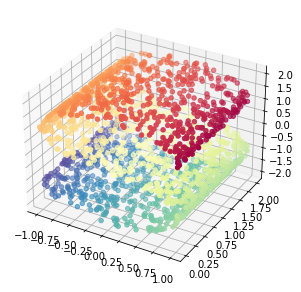

In [47]:
# plotting the S curve
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')

ax.scatter(X[:,0],X[:,1],X[:,2],c=y,cmap=plt.cm.Spectral)
plt.show()

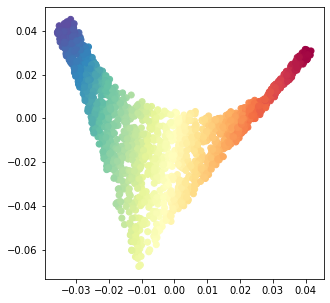

In [48]:
model = LocallyLinearEmbedding(n_neighbors=8)
X_lle_8 = model.fit_transform(X)
fig = plt.figure(figsize=(5,5))
plt.scatter(X_lle_8[:,0],X_lle_8[:,1],c=y,cmap='Spectral')
plt.show()

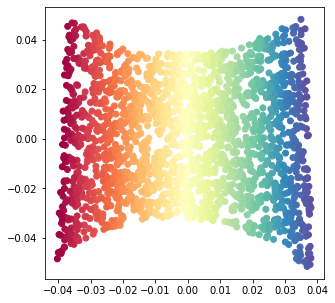

In [49]:
model = LocallyLinearEmbedding(n_neighbors=12)
X_lle_12 = model.fit_transform(X)
fig = plt.figure(figsize=(5,5))
plt.scatter(X_lle_12[:,0],X_lle_12[:,1],c=y,cmap='Spectral')
plt.show()

In [50]:
# Implementing LLE from scratch
def LLE(X, n_neighbors=5, n_components=2, eps=1e-4):
    n_samples, n_features = X.shape
    
    distances = np.zeros((n_samples, n_samples))
    neighbors = np.zeros((n_samples, n_neighbors), dtype=int)
    
    for i in range(n_samples):
        distance = np.sum((X-X[i])**2, axis=1)
        indices = np.argsort(distance)
        neighbors[i] = indices[1:n_neighbors+1]
        distances[i,:n_neighbors] = distance[neighbors[i]]
    
    W = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        Z = X[neighbors[i]]-X[i]
        C = np.dot(Z, Z.T)
        ones = np.ones((n_neighbors, 1))
        w = np.linalg.solve(C+eps*np.eye(n_neighbors), ones)
        w /= np.sum(w)
        W[i, neighbors[i]] = w.ravel()
    
    M = np.eye(n_samples)-W
    eig_val, eig_vec = eigh(np.dot(M.T, M))
    ind = sorted(range(len(eig_val)), key=lambda k: eig_val[k])
    
    embedding = eig_vec[:,ind[1:n_components+1]]
    return embedding

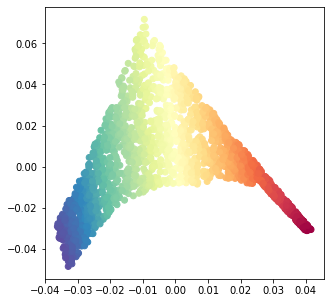

In [51]:
X_s_lle = LLE(X, 8, 2)
fig = plt.figure(figsize=(5,5))
plt.scatter(X_s_lle[:,0],X_s_lle[:,1],c=y,cmap='Spectral')
plt.show()

In [52]:
# Implementing ANLLE from scratch
class ANLLE:
    def __init__(self, n=20, low=8, n_components=2, eps=5e-4):
        self.n = n
        self.low = low
        self.n_components = n_components
        self.eps = eps
    
    def fit_transform(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape
        all_distances = np.zeros((self.n_samples, self.n_samples))
        distances = np.zeros((self.n_samples, self.n+1))
        indices = np.zeros((self.n_samples, self.n+1), dtype=int)
        self.neighbors = [None]*self.n_samples
        
        for i in range(self.n_samples):
            distance = np.sum((X-X[i])**2, axis=1)
            all_distances[i] = distance
            indices[i] = np.argsort(all_distances[i])[:self.n+1]
            distances[i] = all_distances[i][indices[i]]
        
        self.alpha = np.mean(distances,axis=1)
        self.beta = np.mean(self.alpha)

        for i in range(self.n_samples):
            self.d = self.beta if self.alpha[i]<self.beta else (self.alpha[i]+self.beta)/2
            self.neighbors[i] = indices[i][distances[i]<self.d][1:]
        
        self.W = np.zeros((self.n_samples, self.n_samples))
        self.n_neighbors = [len(i) for i in self.neighbors]
        
        self.Kmax = np.max(self.n_neighbors)
        self.Kmean = int(np.mean(self.n_neighbors))
        
        for i in range(self.n_samples):
            Z = X[self.neighbors[i]]-X[i]
            C = np.dot(Z, Z.T)
            ones = np.ones((len(self.neighbors[i]), 1))
            w = np.linalg.solve(C+self.eps*np.eye(len(self.neighbors[i])), ones)
            w /= np.sum(w)
            self.W[i, self.neighbors[i]] = w.ravel()
        
        M = np.eye(self.n_samples)-self.W
        eig_val, eig_vec = eigh(np.dot(M.T, M))
        ind = sorted(range(len(eig_val)), key=lambda k: eig_val[k])
        
        self.embeddings = eig_vec[:,ind[1:self.n_components+1]]
        return self.embeddings

    def transform(self, y):
        n_new_samples = y.shape[0]
        all_distances = np.zeros((n_new_samples, self.n_samples))
        neighbors = np.zeros((n_new_samples, self.Kmean), dtype=int)
        for i in range(n_new_samples):
            distance = np.sum((self.X-y[i])**2, axis=1)
            all_distances[i] = distance
            neighbors[i] = np.argsort(all_distances[i])[1:self.Kmean+1]
        
        Wt = np.zeros((n_new_samples, self.n_samples))
        y_trans = np.zeros((n_new_samples, self.n_components))
        for i in range(n_new_samples):
            Z = self.X[neighbors[i]]-y[i]
            C = np.dot(Z, Z.T)
            ones = np.ones((self.Kmean, 1))
            w = np.linalg.solve(C+self.eps*np.eye(self.Kmean), ones)
            w /= np.sum(w)
            Wt[i, neighbors[i]] = w.ravel()
            y_trans[i] = w.T@self.embeddings[neighbors[i]]
        
        return y_trans

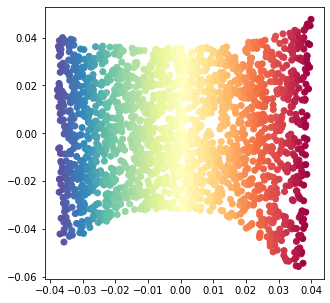

In [53]:
anlle = ANLLE(n=35, low=8, n_components=2, eps=5e-4)
X_s_anlle = anlle.fit_transform(X)
fig = plt.figure(figsize=(5,5))
plt.scatter(X_s_anlle[:,0],X_s_anlle[:,1],c=y,cmap='Spectral')
plt.show()

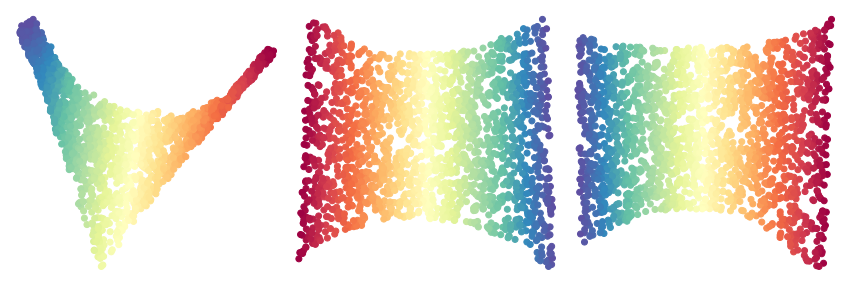

In [54]:
# comparing the models
fig, ax = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'wspace': 0, 'hspace': 0})
ax[0].scatter(X_lle_8[:,0],X_lle_8[:,1],c=y,cmap='Spectral')
ax[1].scatter(X_lle_12[:,0],X_lle_12[:,1],c=y,cmap='Spectral')
ax[2].scatter(X_s_anlle[:,0],X_s_anlle[:,1],c=y,cmap='Spectral')

for ax in ax.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig("manifold_results.jpg", bbox_inches=0)
plt.show()

In [30]:
# loading umist face dataset
data = arff.loadarff('umistfacescropped.arff')
df = pd.DataFrame(data[0])
X = np.array(df.iloc[:,:-1], dtype=int)
y = np.array(df.iloc[:,-1], dtype=int)

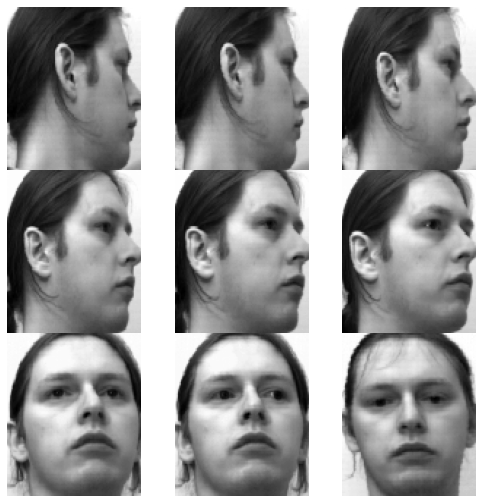

In [44]:
fig, ax = plt.subplots(3, 3, figsize=(9, 9), gridspec_kw={'wspace': 0, 'hspace': 0})
ax[0][0].imshow(X[0].reshape(112,92), cmap='gray')
ax[0][1].imshow(X[1].reshape(112,92), cmap='gray')
ax[0][2].imshow(X[6].reshape(112,92), cmap='gray')
ax[1][0].imshow(X[14].reshape(112,92), cmap='gray')
ax[1][1].imshow(X[16].reshape(112,92), cmap='gray')
ax[1][2].imshow(X[18].reshape(112,92), cmap='gray')
ax[2][0].imshow(X[32].reshape(112,92), cmap='gray')
ax[2][1].imshow(X[34].reshape(112,92), cmap='gray')
ax[2][2].imshow(X[36].reshape(112,92), cmap='gray')

for ax in ax.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig("dataset.jpg", bbox_inches=0)
plt.show()

In [32]:
# creating training and test set

class_indices = {}

for cls in set(y):
    class_indices[cls] = []

for i, cls in enumerate(y):
    class_indices[cls].append(i)

test_indices = []

for cls_indices in class_indices.values():
    random.shuffle(cls_indices)
    test_indices.extend(cls_indices[:5])

random.seed(100)
random.shuffle(test_indices)
train_indices = [i for i in range(X.shape[0]) if i not in test_indices]

X_test = X[test_indices]
y_test = y[test_indices]

X_train = X[train_indices]
y_train = y[train_indices]

In [34]:
anlle = ANLLE(n=35, low=5, n_components=81, eps=5e-4)
X_train_anlle = anlle.fit_transform(X_train)
X_test_anlle = anlle.transform(X_test)

In [35]:
anlle_classifier = KNeighborsClassifier()
anlle_classifier.fit(X_train_anlle, y_train)

KNeighborsClassifier()

In [36]:
y_pred = anlle_classifier.predict(X_test_anlle)
anlle_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using ANLLE: {anlle_accuracy}")

Accuracy using ANLLE: 0.95


In [37]:
model = LocallyLinearEmbedding(n_neighbors=3,n_components=81)
X_train_lle = model.fit_transform(X_train)
X_test_lle = model.transform(X_test)

In [38]:
lle_classifier = KNeighborsClassifier(n_neighbors=3)
lle_classifier.fit(X_train_lle, y_train)

KNeighborsClassifier(n_neighbors=3)

In [39]:
y_pred = lle_classifier.predict(X_test_lle)
lle_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using LLE: {lle_accuracy}")

Accuracy using LLE: 0.91
